# Кластеризация торговых точек
Целью данного проекта было разделение торговых точек на группы в зависимости от структуры спроса.
 Под спросом (или востребованностью) на товары заказчик понимает количество приобретенных единиц товара на 1000 чеков при условии наличия товара на полке. Этот показатель заранее рассчитан и хранится в базе данных. Кроме того стояла задача проанализировать именно структуру спроса - то есть учитывть при рассчетах показатели спроса в разные "типы дней". В индекс дня была включена информация о дне недели, сезоне, погодных условиях (в целом - описание дня).

Данное разделение заказчик потом использовал для объединения статистики продаж в рамках кластеров и уточнения прогнозов продаж. Кроме того, кластеризацию предполагалось использовать для предсказания востребованности отдельных номенклатурных позиций в точках, где эти позиции никогда не продавались.

## Процесс кластеризации
Для проведения кластеризации были введены параметры типа: «показатель спроса на данную группу товара в данный тип дня». 
Посмотрим на внешний вид получившихся данных.

In [35]:
import pandas as pd
import numpy as np
from pyod.models.ecod import ECOD
from sklearn.preprocessing import StandardScaler

In [36]:
raw_data = pd.read_json('raw_data.json')
df = raw_data.copy()
df.head()

,Вареники_0:0:1,Колбасы сырокопченые_0:0:1,Сыры_0:0:1,Завтраки_0:0:1,Чай_0:0:1,Выпечка_0:0:1,Пироги_0:0:1,Вторые блюда_0:0:1,Заливные_0:0:1,"Салаты, закуски_0:0:1",...,Драже_0:0:2,Драже_0:2:2,Суперфуды_0:3:2,Суперфуды_0:3:0,Драже_3:1:0,Суперфуды_0:0:1,Суперфуды_3:1:0,Суперфуды_3:1:1,Конфеты_0:3:1,Суперфуды_0:0:2
80da3868dd5d421311ecc79bc6073f26,4.52,0.72,1.27,18.10,13.57,90.50,95.02,122.17,31.67,49.77,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80da3868dd5d421311ecc79c12c3b45e,6.69,3.34,10.03,13.38,20.07,150.50,43.48,83.61,50.17,73.58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80da3868dd5d421311ecc79cd8c8d327,19.70,NaN,2.41,24.63,19.70,236.45,39.41,88.67,68.97,59.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80da3868dd5d421311ecc79d22c7b890,22.22,NaN,7.06,33.33,11.11,144.44,172.22,183.33,33.33,72.22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80da3868dd5d421311ecc79d98ffda59,4.46,0.80,18.88,8.93,NaN,196.43,80.36,156.25,26.79,102.68,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
df = df.reset_index()
df.drop('index', axis = 1, inplace=True)
df.head()

,Вареники_0:0:1,Колбасы сырокопченые_0:0:1,Сыры_0:0:1,Завтраки_0:0:1,Чай_0:0:1,Выпечка_0:0:1,Пироги_0:0:1,Вторые блюда_0:0:1,Заливные_0:0:1,"Салаты, закуски_0:0:1",...,Драже_0:0:2,Драже_0:2:2,Суперфуды_0:3:2,Суперфуды_0:3:0,Драже_3:1:0,Суперфуды_0:0:1,Суперфуды_3:1:0,Суперфуды_3:1:1,Конфеты_0:3:1,Суперфуды_0:0:2
0,4.52,0.72,1.27,18.10,13.57,90.50,95.02,122.17,31.67,49.77,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6.69,3.34,10.03,13.38,20.07,150.50,43.48,83.61,50.17,73.58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,19.70,NaN,2.41,24.63,19.70,236.45,39.41,88.67,68.97,59.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,22.22,NaN,7.06,33.33,11.11,144.44,172.22,183.33,33.33,72.22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.46,0.80,18.88,8.93,NaN,196.43,80.36,156.25,26.79,102.68,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Посмотрим на размер данных (количество магазинов, параметров):

In [38]:
df.shape

(50, 750)

In [39]:
df.describe()

,Вареники_0:0:1,Колбасы сырокопченые_0:0:1,Сыры_0:0:1,Завтраки_0:0:1,Чай_0:0:1,Выпечка_0:0:1,Пироги_0:0:1,Вторые блюда_0:0:1,Заливные_0:0:1,"Салаты, закуски_0:0:1",...,Драже_0:0:2,Драже_0:2:2,Суперфуды_0:3:2,Суперфуды_0:3:0,Драже_3:1:0,Суперфуды_0:0:1,Суперфуды_3:1:0,Суперфуды_3:1:1,Конфеты_0:3:1,Суперфуды_0:0:2
count,42.000000,31.000000,46.000000,47.000000,32.000000,49.000000,49.000000,49.000000,48.000000,49.000000,...,0.0,0.0,0.0,0.0,1.00,1.00,1.00,0.0,0.0,0.0
mean,15.183333,6.134839,10.607391,22.637447,10.533750,147.671633,72.212245,114.992857,41.352917,73.113878,...,NaN,NaN,NaN,NaN,9.62,5.95,4.76,NaN,NaN,NaN
std,8.774208,5.351157,6.844574,11.386595,5.698449,52.735172,32.465834,46.776130,17.891723,32.522136,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,3.610000,0.490000,1.270000,5.100000,2.740000,65.310000,19.010000,22.470000,10.200000,32.880000,...,NaN,NaN,NaN,NaN,9.62,5.95,4.76,NaN,NaN,NaN
25%,7.262500,2.165000,6.752500,13.335000,5.612500,110.240000,53.160000,82.350000,29.380000,54.790000,...,NaN,NaN,NaN,NaN,9.62,5.95,4.76,NaN,NaN,NaN
50%,14.025000,4.780000,9.365000,23.530000,10.310000,142.860000,68.970000,107.140000,41.620000,68.380000,...,NaN,NaN,NaN,NaN,9.62,5.95,4.76,NaN,NaN,NaN
75%,20.877500,7.855000,14.215000,28.780000,12.730000,176.030000,92.420000,138.080000,53.130000,84.630000,...,NaN,NaN,NaN,NaN,9.62,5.95,4.76,NaN,NaN,NaN
max,33.710000,22.470000,33.710000,48.030000,22.860000,323.650000,172.220000,229.050000,98.250000,203.060000,...,NaN,NaN,NaN,NaN,9.62,5.95,4.76,NaN,NaN,NaN


## Предобработка данных
Как мы видим ниже, получившиеся параметры содержат большое количество отсутствующих значений. Первым шагом предобработки было что-то с этим сделать.

In [40]:
df = df.fillna(value=np.nan)
percent_missing = round(100*(df.isnull().sum())/len(df), 2)
print(percent_missing)


Вареники_0:0:1                 16.0
Колбасы сырокопченые_0:0:1     38.0
Сыры_0:0:1                      8.0
Завтраки_0:0:1                  6.0
Чай_0:0:1                      36.0
                              ...  
Суперфуды_0:0:1                98.0
Суперфуды_3:1:0                98.0
Суперфуды_3:1:1               100.0
Конфеты_0:3:1                 100.0
Суперфуды_0:0:2               100.0
Length: 750, dtype: float64


In [41]:
import seaborn as sns

<Axes: >

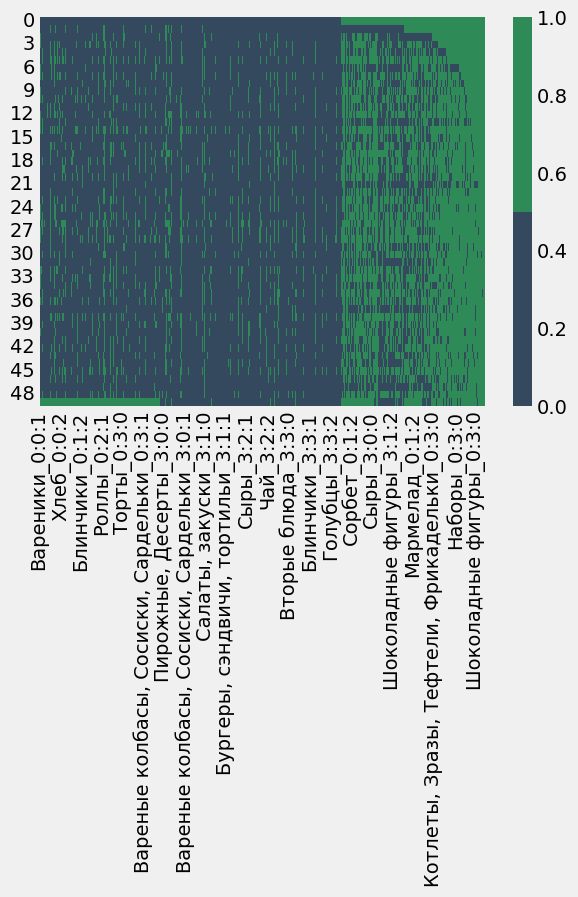

In [42]:
colours = ['#34495E', 'seagreen'] 

sns.heatmap(df.isnull(), cmap=sns.color_palette(colours))

Поскольку довольно большое количество параметров оказываются "бесполезными" - не несут ценной информации, так как отсутствуют для большинства магазинов, было принято решение их удалить.
 (Были испробованы разные методы восстановления, в том числе метод Multiple Imputation by Chained Equations (MICE). Однако в сравнении с кластеризацией, проведенной на полных данных, полученных удалением, они показали худшие результаты. К тому же исходя из логики задачи это кажется подходящим вариантом, чтобы не предсказывать пропущенные данные, которые в дальненйшем клиент и хочет прогнозировать исходя из результатов кластеризации.)

In [43]:
df = df.dropna(axis=1)
df.shape

(50, 187)

Следующим шагом было удаление выбросов. Это выполнянлось при помощи метода ECOD (Unsupervised Outlier Detection) библиотеки PyOD. 
После этого проведено масштабирование при помощи Standart Scaler.

In [44]:
clf = ECOD()
clf.fit(df)
outliers = clf.predict(df)

df["outliers"] = outliers

df_no_outliers = df[df["outliers"] == 0]
df = df_no_outliers.drop(["outliers"], axis = 1)

df_not_scaled = df.copy() # for later

scaler = StandardScaler()
col_names =df.columns
features = df[col_names]
df[col_names] = scaler.fit_transform(features.values)

df.to_json('preprocessed_df.json')


In [45]:
df.shape

(45, 187)

## Перейдем непосредственно к решению задачи кластеризации. 

Первый опробованный метод - K-means++. Для начало необходимо определить количество кластеров, на которые следует разбивать набор данных. Всё стандартно - применяем метод локтя.

In [46]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
from kneed import KneeLocator

In [47]:
import warnings
warnings.filterwarnings("ignore")

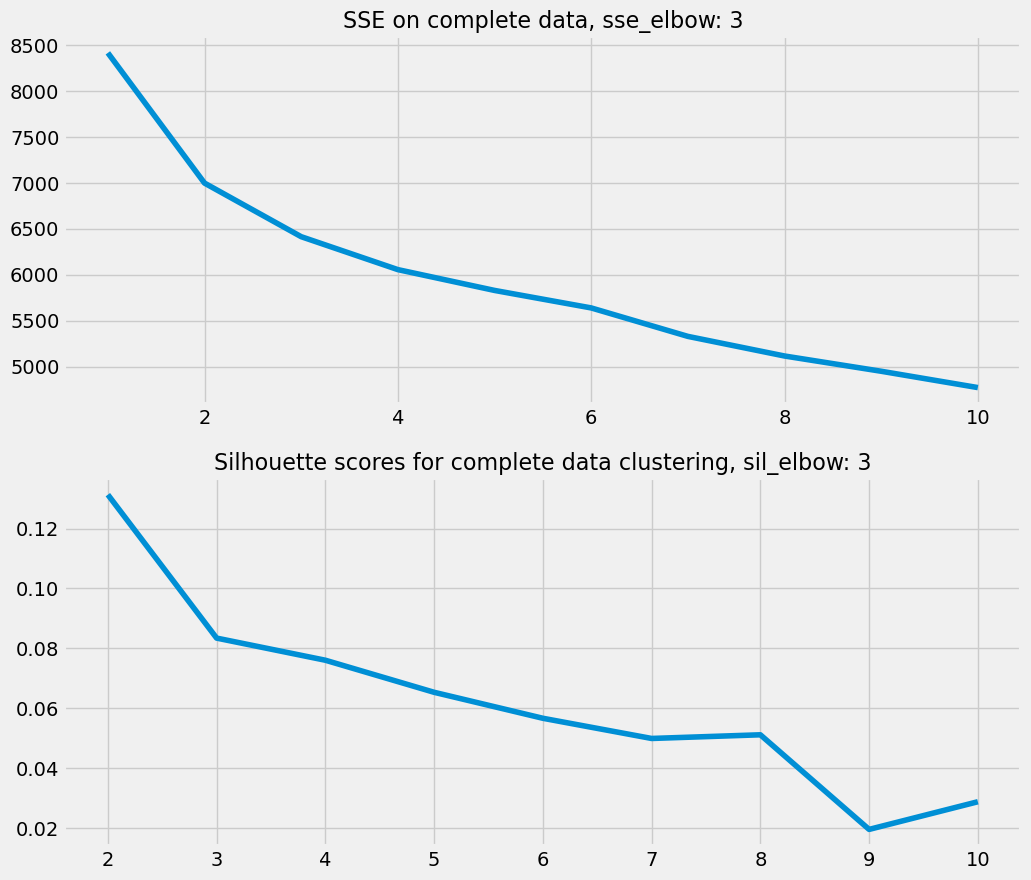

In [48]:
kmeans_kwargs = {
    "init": "k-means++",
    "max_iter": 100,
    "random_state": 0,
}
sse = []
silhouette_coefficients = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df)
    sse.append(kmeans.inertia_)


for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df)
    score = silhouette_score(df, kmeans.labels_)
    silhouette_coefficients.append(score)

kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

sse_elbow = kl.elbow
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[11, 10])

ax1.plot(range(1, 11), sse)
ax1.set_title(f"SSE on complete data, sse_elbow: {sse_elbow}", fontsize=16)


sil_kl = KneeLocator(
    range(2, 11), silhouette_coefficients, curve="convex", direction="decreasing"
)

sil_elbow = sil_kl.elbow

ax2.plot(range(2, 11), silhouette_coefficients)
ax2.set_title(f"Silhouette scores for complete data clustering, sil_elbow: {sil_elbow}", fontsize=16)

plt.style.use("fivethirtyeight")
plt.show()



Таким образом, выбираем разбиение на 3 кластера.

In [49]:
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

## Визуализируем полученные результаты при помощи метода главных компонент (PCA).
Точнее KernelPCA, но это подробности.

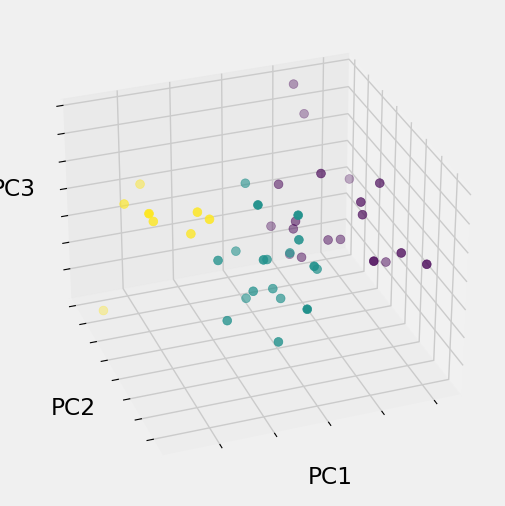

In [50]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

df_reduced = KernelPCA(n_components=3).fit_transform(df)
kmeans = KMeans(n_clusters=3, **kmeans_kwargs)
kmeans.fit(df_reduced)

labels = kmeans.labels_
ax.scatter(
    df_reduced[:, 0],
    df_reduced[:, 1],
    df_reduced[:, 2],
    c=labels,
    s=40,
)
ax.set_xlabel("PC1")
ax.xaxis.set_ticklabels([])
ax.set_ylabel("PC2")
ax.yaxis.set_ticklabels([])
ax.set_zlabel('PC3')
ax.zaxis.set_ticklabels([])

plt.show()

In [51]:
print(f"Davies Bouldin score: {davies_bouldin_score(df_reduced, kmeans.labels_)}")
print(f"Calinski–Harabasz Score: {calinski_harabasz_score(df_reduced, kmeans.labels_)}")
print(f"Silhouette Score: {silhouette_score(df_reduced, kmeans.labels_)}")

Davies Bouldin score: 1.060863255506112
Calinski–Harabasz Score: 28.189386576093078
Silhouette Score: 0.3232772551646047


Индекс Дэвиса Болдуина должен стремиться к нулю, Калински-Харабаза чем больше тем лучше, а оценка Силуэта равна единице при идеальной кластеризации. 
Результаты не очень хорошие, но по визуализации понятно, что возможно это лучший результат, который можно получить.

Попробуем другой метод кластеризации - иерархический.

In [52]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

In [53]:
def plot_dendrogram(model, **kwargs):

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


In [54]:
model = AgglomerativeClustering(n_clusters=3, affinity='cosine', linkage='average', distance_threshold=None)

model = model.fit(df)
clusters_predict = model.labels_
print(f"Davies Bouldin score: {davies_bouldin_score(df,clusters_predict)}")
print(f"Calinski–Harabasz Score: {calinski_harabasz_score(df,clusters_predict)}")
print(f"Silhouette Score: {silhouette_score(df,clusters_predict)}")


Davies Bouldin score: 2.450433195350578
Calinski–Harabasz Score: 6.207325063002623
Silhouette Score: 0.06130021025400847


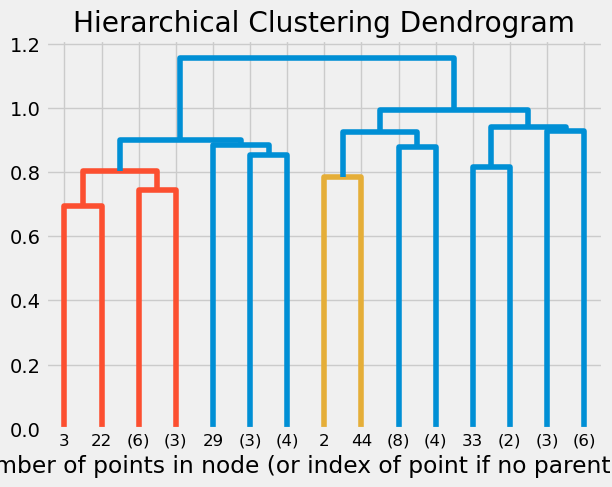

In [55]:
model = AgglomerativeClustering(affinity='cosine', linkage='average', distance_threshold=0, n_clusters=None)
model = model.fit(df)
plt.title("Hierarchical Clustering Dendrogram")

plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

Как видим, результаты оказались хуже. На самом деле были опробованы и другие алгоритмы кластеризации, но К-средних оказался наиболее эффективным. 

Поскольку задача была поставлена бизнесом, был запрос на объяснение результатов кластеризации.  Некоторая попытка представлена ниже. 
 

In [56]:
import lightgbm as lgb
import shap

Не обращайте внимание. Это нужно, чтобы переименовать заголовки. Lightgbm не принимает названия с кириллицей.

In [57]:
import re
from transliterate import translit

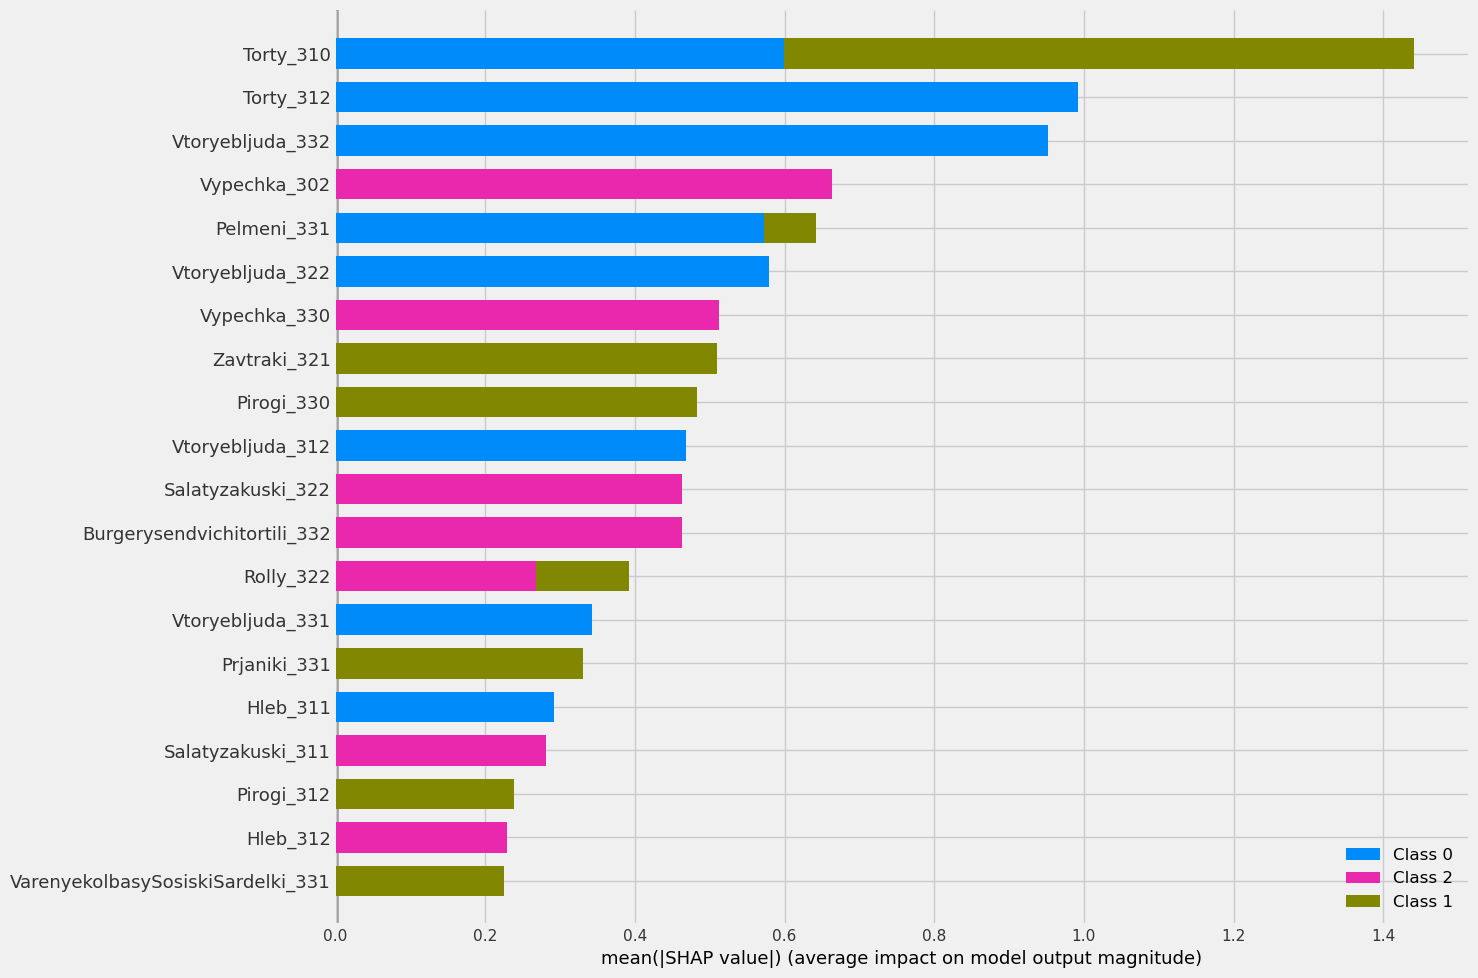

In [69]:
# SHAP values
clf_km = lgb.LGBMClassifier(colsample_by_tree=0.8, verbose=-1)
data = df.rename(columns = lambda x: translit(x, language_code='ru', reversed=True))
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
clf_km.fit(X = data , y = labels, feature_name = "auto", categorical_feature = "auto")

explainer_km = shap.TreeExplainer(clf_km)
shap_values_km = explainer_km.shap_values(data)
shap.summary_plot(shap_values_km, data, plot_type="bar", plot_size=(15, 10))


Значения SHAP (Shapley Additive ExPlanations) —  показывают, как каждый признак влияет на каждый окончательный прогноз, а также значимость каждого признака по сравнению с другими.
Из представленных данных сделать вывод, что группы товаров, более других влияющие на результат – торты и выпечка, вторые блюда.
